# Example of FedAvg and FedProx for two datasets: MNIST iid and MNIST non-iid



In [1]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

## 1. MNIST iid

### Data loading and visualization

First of all, we load the train and test MNIST dataset and randomly split them in 3 non-overlapping datasets. We will use them for the 3 different nodes.

In [ ]:
from create_MNIST_datasets import get_MNIST, plot_samples
mnist_iid_train_dls, mnist_iid_test_dls = get_MNIST("iid",
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

In the following cell we plot some samples from the 3 datasets

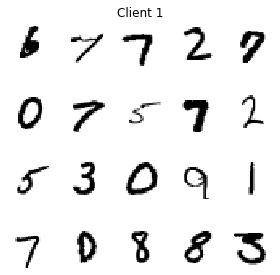

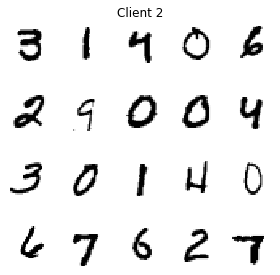

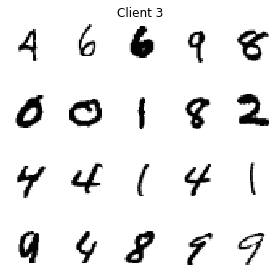

In [3]:
plot_samples(next(iter(mnist_iid_train_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_iid_train_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_iid_train_dls[2])), 0, "Client 3")

As you can see, all the digits are represented in each client. Indeed we split the dataset so to have independent and identically distributed (iid) samples.

### Classification

We define a convolutional neural network (CNN) for digits classification. We also define the functions for training, and for computing loss and accuracy.

In [4]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet -> 
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

model_0 = CNN()

In [5]:
def loss_classifier(predictions,labels):
    
    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")
    
    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0
    
    for idx,(features,labels) in enumerate(dataset):
        
        predictions= model(features)
        loss+=loss_f(predictions,labels)
    
    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""
    
    correct=0
    
    for features,labels in iter(dataset):
        
        predictions= model(features)
        
        _,predicted=predictions.max(1,keepdim=True)
        
        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()
        
    accuracy = 100*correct/len(dataset.dataset)
        
    return accuracy


def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""
    
    total_loss=0
    
    for idx, (features,labels) in enumerate(train_data):
        
        optimizer.zero_grad()
        
        predictions= model(features)
        
        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss
        
        loss.backward()
        optimizer.step()
        
    return total_loss/(idx+1)



def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):
    
    model_0=deepcopy(model)
    
    for e in range(epochs):
        local_loss=train_step(model,model_0,mu,optimizer,train_data,loss_f)
        
    return float(local_loss.detach().numpy())


def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    
    tensor_1=list(model_1.parameters())
    tensor_2=list(model_2.parameters())
    
    norm=sum([torch.sum((tensor_1[i]-tensor_2[i])**2) 
        for i in range(len(tensor_1))])
    
    return norm


def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)
        

### Aggregation strategies

Federated learning requires to define an aggregation strategy, i.e. a method to combine the local models coming from the clients into a global one.

**Federated averaging**

The standard and simplest aggregation strategy is federated averaging ([FedAvg](https://arxiv.org/pdf/1602.05629.pdf)).

The learning is performed in rounds. At each round, the server samples a set of $m$ clients (out of the total $K$ clients) which will be considered for the current iteration and sends them the current global model.
These clients update the parameters of their local copy of the model by optimizing the loss $F_k$ on their local training data using SGD for $E$ epochs. At the end of the round, the local parameters are sent to the server, which aggregates them by performing a weighted average. The aggregated parameters define the global model for the next round.

**FedProx**

Another strategy is [FedProx](https://arxiv.org/pdf/1812.06127.pdf), which is a generalization of FedAvg with some modifications to address heterogeneity of data and systems.

The learning is again performed in rounds. At each round, the server samples a set of $m$ clients and sends them the current global model.
Differently from FedAvg, here the clients optimize a regularized loss with a proximal term. In particular, the new function to minimize is $F_k(\omega) + \frac{\mu}{2}||\omega - \omega^t ||^2$, where $F_k$ is the loss, $\omega$ are the local parameter to optimize, and $\omega^t$ are the global parameters at time $t$.   
Moreover we run the local optimization for a variable number of epochs according to the system resources (so that slow clients can also contribute to the training with a reduced number of epochs). 
As for FedAvg, the local parameters are sent to the server and aggregated.

**NOTE** FedAvg is a particular case of FedProx with $\mu=0$. So, we just need to implement the code for FedProx, which we will be used also for FedAvg by setting the parameter *mu=0*

### EXERCISE
Complete the model aggregation function

In [12]:
def average_models(model, clients_models_hist:list , weights:list):
    """Creates the new model of a given iteration with the models of the other
    clients
    -model is the current global model
    - clients_models_hist is the list of each client's updated local model
    - weights is the list of each client's weight"""
    
    ###SET MODEL'S PARAMETERS TO 0
    
    
    for k, client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    ###RETURN THE NEW GLOBAL MODEL

In [7]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0, 
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the 
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration
    
    returns :
        - `model`: the final global model 
    """
        
    loss_f=loss_classifier
    
    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)
    
    
    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach()) 
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy() 
        for tens_param in list(model.parameters())]]
    models_hist = []
    
    
    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')
    
    for i in range(n_iter):
        
        clients_params=[]
        clients_models=[]
        clients_losses=[]
        
        for k in range(K):
            
            local_model=deepcopy(model)
            local_optimizer=optim.SGD(local_model.parameters(),lr=lr)
            
            local_loss=local_learning(local_model,mu,local_optimizer,
                training_sets[k],epochs,loss_f)
            
            clients_losses.append(local_loss)
                
            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)    
            clients_models.append(deepcopy(local_model))
        
        
        #CREATE THE NEW GLOBAL MODEL
        model = average_models(deepcopy(model), clients_params, 
            weights=weights)
        models_hist.append(clients_models)
        
        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach()) 
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')
        

        server_hist.append([tens_param.detach().cpu().numpy() 
            for tens_param in list(model.parameters())])
        
        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay
            
    return model, loss_hist, acc_hist

### Federated training with FedAvg

We will now train the model on the 3 clients, using FedAvg aggregation strategy.

**NOTE** In this notebook, during the training, we will consider the 3 clients for each round ($m=K=3$)

In [8]:
# Train with FedAvg -> FedProx with mu=0

n_iter=10

model_f, loss_hist_FA_iid, acc_hist_FA_iid = FedProx( model_0, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, epochs =2, 
    lr =0.1, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.300051132837931 Server Test Accuracy: 9.333333333333332
====> i: 1 Loss: 2.115779399871826 Server Test Accuracy: 43.33333333333333
====> i: 2 Loss: 1.4170910914738972 Server Test Accuracy: 66.33333333333333
====> i: 3 Loss: 0.7694819768269856 Server Test Accuracy: 77.0
====> i: 4 Loss: 0.564457356929779 Server Test Accuracy: 80.33333333333333
====> i: 5 Loss: 0.41685162981351215 Server Test Accuracy: 83.66666666666666
====> i: 6 Loss: 0.2300022691488266 Server Test Accuracy: 91.66666666666666
====> i: 7 Loss: 0.197920819123586 Server Test Accuracy: 89.0
====> i: 8 Loss: 0.13389848669370014 Server Test Accuracy: 91.66666666666666
====> i: 9 Loss: 0.1120482012629509 Server Test Accuracy: 92.33333333333333
====> i: 10 Loss: 0.07799022644758224 Server Test Accuracy: 91.66666666666666


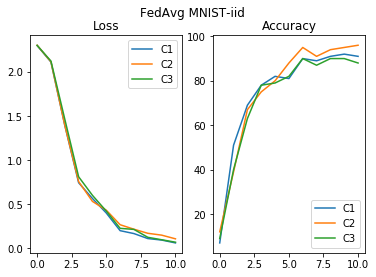

In [9]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    plt.figure()
    
    plt.suptitle(title)

    plt.subplot(1,2,1)
    lines=plt.plot(loss_hist)
    plt.title("Loss")
    plt.legend(lines,["C1", "C2", "C3"])

    plt.subplot(1,2,2)
    lines=plt.plot(acc_hist )
    plt.title("Accuracy")
    plt.legend(lines, ["C1", "C2", "C3"])
    

plot_acc_loss("FedAvg MNIST-iid", loss_hist_FA_iid, acc_hist_FA_iid)

### Federated training with FedProx

We will now train the model on the 3 clients, using FedProx aggregation strategy.

**NOTE** We are going to consider the 3 clients in every round ($m=K=3$) and we assume that they have the same system resources (they will run the same number of epochs each round)

In [10]:
# Train with FedProx, mu=1

n_iter=10

model_f, loss_hist_FP_iid, acc_hist_FP_iid = FedProx( model_0, 
    mnist_iid_train_dls, n_iter, mnist_iid_test_dls, 
    epochs =2, lr =0.1, mu =.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3000512917836504 Server Test Accuracy: 9.333333333333332
====> i: 1 Loss: 2.15874703725179 Server Test Accuracy: 29.666666666666664
====> i: 2 Loss: 1.566962440808614 Server Test Accuracy: 60.33333333333333
====> i: 3 Loss: 1.2437344789505005 Server Test Accuracy: 65.0
====> i: 4 Loss: 0.5378359158833821 Server Test Accuracy: 83.33333333333333
====> i: 5 Loss: 0.43191210428873694 Server Test Accuracy: 86.33333333333333
====> i: 6 Loss: 0.35815815130869544 Server Test Accuracy: 87.33333333333333
====> i: 7 Loss: 0.2918719152609507 Server Test Accuracy: 88.33333333333333
====> i: 8 Loss: 0.2190828174352646 Server Test Accuracy: 89.33333333333333
====> i: 9 Loss: 0.17422165473302204 Server Test Accuracy: 88.66666666666666
====> i: 10 Loss: 0.14906058212121326 Server Test Accuracy: 88.66666666666666


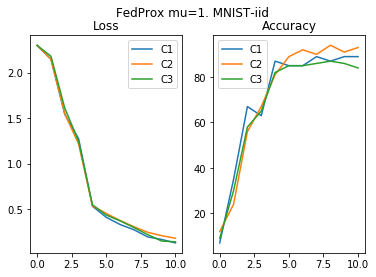

In [11]:
plot_acc_loss("FedProx mu=1. MNIST-iid", loss_hist_FP_iid, acc_hist_FP_iid)

### Conclusion and comparison

We notice that with both aggregation strategies the model converges to a high value of accuracy (consider that we are working with 600 images only). In this case where we have iid dataset across clients, the accuracy of FedAvg and FedProx are comparable.

## 2. MNIST non-iid

We split MNIST using a non-iid sampling. We assign digits 012, 345, 6789 to the 3 different clients.

In [12]:
mnist_non_iid_train_dls, mnist_non_iid_test_dls = get_MNIST("non_iid",
    n_samples_train =200, n_samples_test=100, n_clients =3, 
    batch_size =25, shuffle =True)

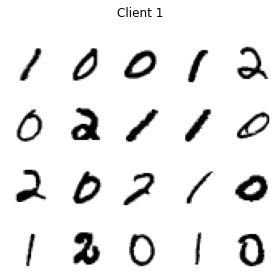

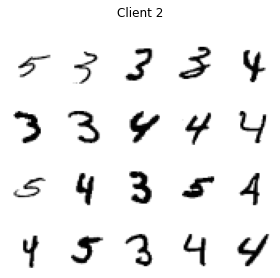

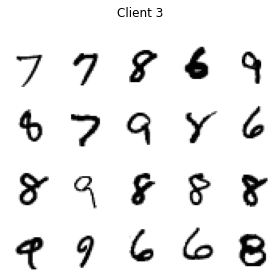

In [13]:
plot_samples(next(iter(mnist_non_iid_train_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_non_iid_train_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_non_iid_train_dls[2])), 0, "Client 3")

### Federated training with FedAvg

### EXERCISE

Train FedAvg for this MNIST non-iid dataset and plot the accuracy and loss evolution during the training

In [15]:
###RUN FedAvg FOR MNIST NON-IID

In [16]:
###PLOT THE RESULTS

Interpret the results.

Compare it with FedAvg for MNIST iid

### Federated training with FedProx


### EXERCISE

Run FedProx for MNIST non-iid and conclude.

Look at the impact of the learning rate and the number of epochs on the convergence speed and model performances.

### Conclusion and comparison

Also in the non-iid case both aggregation methods yields good results in term of accuracy. FedProx is performing slighly better, since it is able to compensate for the heterogeneity of the data across the different clients

## Extra: Synthetic MNIST non-iid

We create a synthetic dataset of noisy digits with 3 channels and a different rotation for every channel. We split it across clients using a non-iid sampling, assigning digits 012, 345, 6789 to the 3 different clients.

In [18]:
C= {
     'n_samples_train': 200,
     'font':'Inconsolata',
     'tilt': [0, 45, 90],
     'std_tilt': 10, #std on the tilt,
     'seed':0
     }
C['n_samples']= int(1.5 * C['n_samples_train']) #20% more for the testing set

C1 =deepcopy(C)
C1['numbers'] = [0, 1, 2]

C2=deepcopy(C)
C2['numbers'] = [3, 4, 5]

C3=deepcopy(C)
C3['numbers']= [6, 7, 8, 9]

clients = [C1, C2, C3]

In [19]:
from create_synthetic_MNIST_datasets import get_synth_MNIST
custom_mnist_train, custom_mnist_test = get_synth_MNIST(
    clients, batch_size =10)

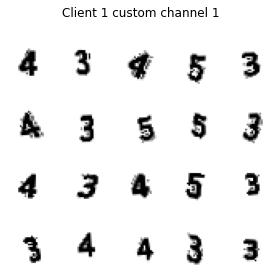

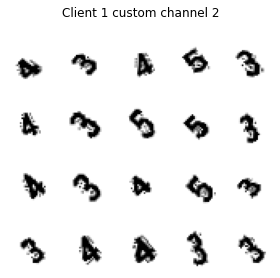

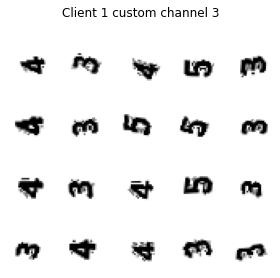

In [20]:
custom_mnist_train[1].dataset.plot_samples(0, "Client 1 custom channel 1")
custom_mnist_train[1].dataset.plot_samples(1, "Client 1 custom channel 2")
custom_mnist_train[1].dataset.plot_samples(2, "Client 1 custom channel 3")

In [21]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet -> 
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

model_1 = CNN()

### Federated training with FedAvg

In [22]:
n_iter=20

model_f, loss_hist_FA_niid, acc_hist_FA_niid = FedProx( model_1, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=2, lr=0.1, mu=0)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.302333037058512 Server Test Accuracy: 12.0
====> i: 1 Loss: 2.272705078125 Server Test Accuracy: 12.0
====> i: 2 Loss: 2.106392423311869 Server Test Accuracy: 21.333333333333332
====> i: 3 Loss: 1.6988290150960286 Server Test Accuracy: 47.99999999999999
====> i: 4 Loss: 1.215367039044698 Server Test Accuracy: 53.666666666666664
====> i: 5 Loss: 1.1272305647532144 Server Test Accuracy: 58.66666666666666
====> i: 6 Loss: 0.8320387800534566 Server Test Accuracy: 68.33333333333333
====> i: 7 Loss: 0.6955994764963785 Server Test Accuracy: 69.33333333333333
====> i: 8 Loss: 1.1870109736919403 Server Test Accuracy: 62.0
====> i: 9 Loss: 0.6495806078116099 Server Test Accuracy: 68.0
====> i: 10 Loss: 1.100920557975769 Server Test Accuracy: 68.66666666666666
====> i: 11 Loss: 0.5672701994578043 Server Test Accuracy: 73.66666666666666
====> i: 12 Loss: 0.6078662524620692 Server Test Accuracy: 66.666

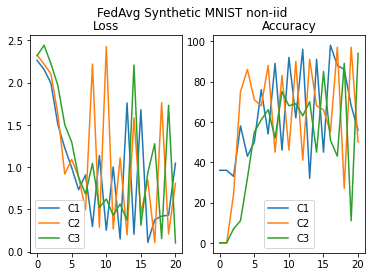

In [23]:
plot_acc_loss("FedAvg Synthetic MNIST non-iid", loss_hist_FA_niid, acc_hist_FA_niid)

### Federated training with FedProx

In [24]:
n_iter=20

model_f, loss_hist_FP_niid, acc_hist_FP_niid = FedProx( model_1, custom_mnist_train, 
    n_iter, custom_mnist_test, epochs=2, lr=0.1, mu=.3)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.302333037058512 Server Test Accuracy: 12.0
====> i: 1 Loss: 2.2694875399271646 Server Test Accuracy: 11.0
====> i: 2 Loss: 2.205150802930196 Server Test Accuracy: 22.333333333333332
====> i: 3 Loss: 1.9699933926264444 Server Test Accuracy: 38.666666666666664
====> i: 4 Loss: 1.629088004430135 Server Test Accuracy: 46.0
====> i: 5 Loss: 1.3054340283075967 Server Test Accuracy: 51.33333333333333
====> i: 6 Loss: 1.2765230337778726 Server Test Accuracy: 48.66666666666666
====> i: 7 Loss: 1.1138799786567688 Server Test Accuracy: 59.0
====> i: 8 Loss: 0.8983448147773743 Server Test Accuracy: 68.0
====> i: 9 Loss: 0.842544396718343 Server Test Accuracy: 63.33333333333333
====> i: 10 Loss: 0.8188411394755045 Server Test Accuracy: 62.66666666666666
====> i: 11 Loss: 0.7055371999740601 Server Test Accuracy: 70.66666666666666
====> i: 12 Loss: 0.6621905962626139 Server Test Accuracy: 73.0
====> i: 1

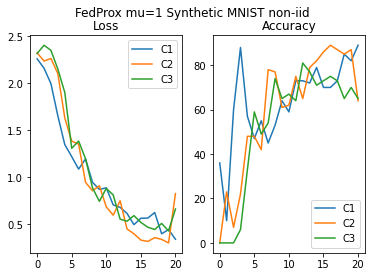

In [25]:
plot_acc_loss("FedProx mu=1 Synthetic MNIST non-iid", loss_hist_FP_niid, acc_hist_FP_niid)